In [2]:
import timm

In [3]:
model = timm.create_model("timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k", pretrained=True)
model.eval()

model.safetensors:   0%|          | 0.00/257M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [4]:
# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [5]:
from torchvision.datasets import CIFAR10
from hw2 import PROJECT_ROOT

dataset = CIFAR10(root=PROJECT_ROOT / "data", train=False)

In [6]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 3)

In [7]:
import torch

img, label = dataset[0]
output = model(transforms(img).unsqueeze(0))
top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

In [8]:
top5_probabilities, top5_class_indices

(tensor([[28.0796, 16.0139, 10.7077, 10.2561,  4.7140]],
        grad_fn=<TopkBackward0>),
 tensor([[281, 901, 282, 285, 728]]))

In [21]:
import datasets

imagenet = datasets.get_dataset_infos("ILSVRC/imagenet-1k")

In [33]:
type(imagenet["default"].features)

datasets.features.features.Features

In [38]:
labels = imagenet["default"].features["label"].names

In [40]:
len(labels)

1000

In [42]:
top5_classes = [labels[i] for i in top5_class_indices[0]]
top5_classes

['tabby, tabby cat', 'whiskey jug', 'tiger cat', 'Egyptian cat', 'plastic bag']

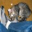

In [43]:
img

In [45]:
# Finetune the model

type(model)

timm.models.vision_transformer.VisionTransformer

In [57]:
from timm.models import VisionTransformer

model: VisionTransformer
model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=10)
# Freeze all layers except the head
for name, param in model.named_parameters():
    if "head" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Check if the head parameters are trainable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name}")

Trainable parameter: head.weight
Trainable parameter: head.bias


In [58]:
dataset = CIFAR10(root=PROJECT_ROOT / "data", train=True, transform=transforms)

In [59]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
model.to("cuda")
model.train()
for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to("cuda"), labels.to("cuda")
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % 2000 == 1999:
        print(f"Loss: {loss.item()}")

Loss: 0.00013517658226191998
Loss: 0.039326928555965424
Loss: 0.0002367269480600953
Loss: 1.5784063339233398
Loss: 2.115956021953025e-06
Loss: 0.0


In [61]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [62]:
test_loader = DataLoader(CIFAR10(root=PROJECT_ROOT / "data", train=False, transform=transforms), batch_size=128, shuffle=False, num_workers=2)

In [64]:
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [71]:
cifar10 = CIFAR10(root=PROJECT_ROOT / "data", train=False)

In [72]:
from sklearn import metrics

print(metrics.classification_report(true_labels, predictions, target_names=cifar10.classes, digits=4))

              precision    recall  f1-score   support

    airplane     0.9855    0.9520    0.9685      1000
  automobile     0.9947    0.9310    0.9618      1000
        bird     0.9157    0.9780    0.9458      1000
         cat     0.9616    0.9010    0.9303      1000
        deer     0.9675    0.9830    0.9752      1000
         dog     0.9489    0.9470    0.9479      1000
        frog     0.9658    0.9880    0.9768      1000
       horse     0.9939    0.9830    0.9884      1000
        ship     0.9809    0.9760    0.9784      1000
       truck     0.9254    0.9920    0.9575      1000

    accuracy                         0.9631     10000
   macro avg     0.9640    0.9631    0.9631     10000
weighted avg     0.9640    0.9631    0.9631     10000



In [73]:
# Save the model
torch.save(model.state_dict(), PROJECT_ROOT / "models/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_cifar10.pth")